In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

from urllib2 import Request, urlopen
from urllib import urlencode


def _request(symbol, stat):
    url = 'http://finance.yahoo.com/d/quotes.csv?s=%s&f=%s' % (symbol, stat)
    req = Request(url)
    resp = urlopen(req)
    return str(resp.read().decode('utf-8').strip())


def get_historical_prices(symbol, start_date, end_date):
    """
    Get historical prices for the given ticker symbol.
    Date format is 'YYYY-MM-DD'

    Returns a nested dictionary (dict of dicts).
    outer dict keys are dates ('YYYY-MM-DD')
    """
    params = urlencode({
        's': symbol,
        'a': int(start_date[5:7]) - 1,
        'b': int(start_date[8:10]),
        'c': int(start_date[0:4]),
        'd': int(end_date[5:7]) - 1,
        'e': int(end_date[8:10]),
        'f': int(end_date[0:4]),
        'g': 'd',
        'ignore': '.csv',
    })
    url = 'http://ichart.yahoo.com/table.csv?%s' % params
    req = Request(url)
    resp = urlopen(req)
    content = str(resp.read().decode('utf-8').strip())
    daily_data = content.splitlines()
    hist_dict = dict()
    keys = daily_data[0].split(',')
    for day in daily_data[1:]:
        day_data = day.split(',')
        date = day_data[0]
        hist_dict[date] = \
            {keys[1]: day_data[1],
             keys[2]: day_data[2],
             keys[3]: day_data[3],
             keys[4]: day_data[4],
             keys[5]: day_data[5],
             keys[6]: day_data[6]}
    return hist_dict

In [71]:
const = pd.read_csv("/Users/jonahwilliams/Downloads/constituents.csv")
enc = LabelEncoder()
const['Sector'] = enc.fit_transform(const['Sector'].values)
const.head()

,Symbol,Name,Sector
0,MMM,3M Co,5
1,ABT,Abbott Laboratories,4
2,ABBV,AbbVie,4
3,ACN,Accenture Plc,6
4,ACE,ACE Limited,3


In [13]:
data = []
for symb in const.Symbol.values:
    try:
        raw = pd.DataFrame(get_historical_prices(symb, '2015-01-01','2015-10-12')).transpose()[['Adj Close']]
        raw.columns = [symb]
        data.append(raw)
    except:
        print symb
        pass

AGN
CFN
COV
NU
PETM
SWY
WAG
WLP


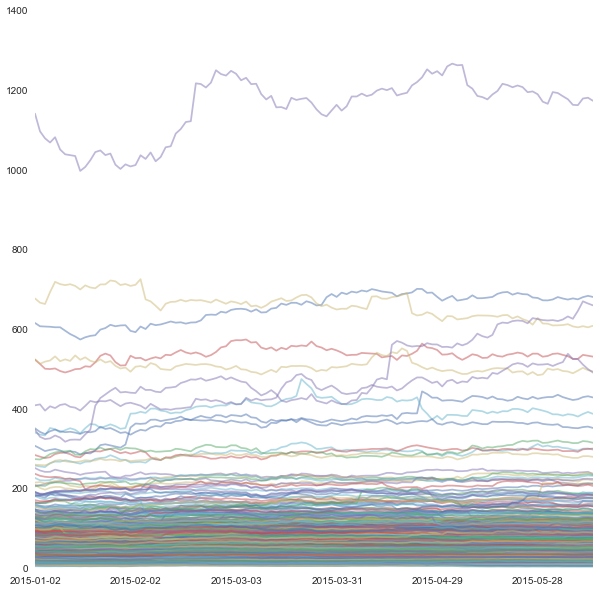

In [26]:
prices = pd.concat(data, axis=1).astype(float)
prices.plot(legend=False, figsize=(10, 10), alpha=0.5)
plt.show()

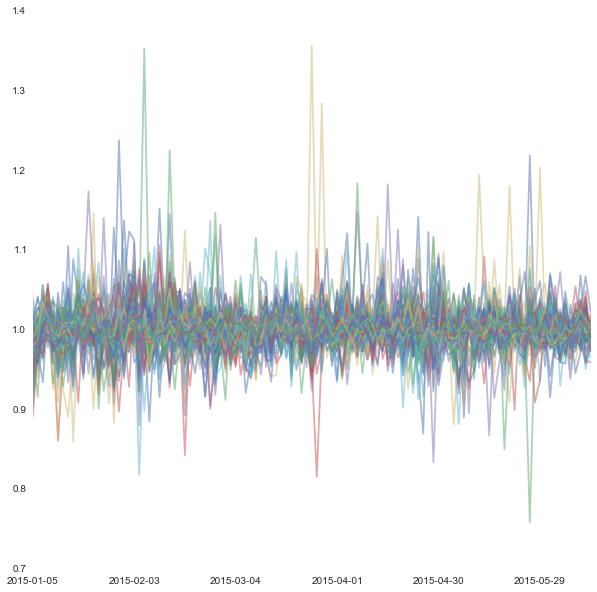

In [32]:
returns = (prices.pct_change() + 1).dropna(axis=0)
returns.plot(legend=False, figsize=(10, 10), alpha=0.5)
plt.show()

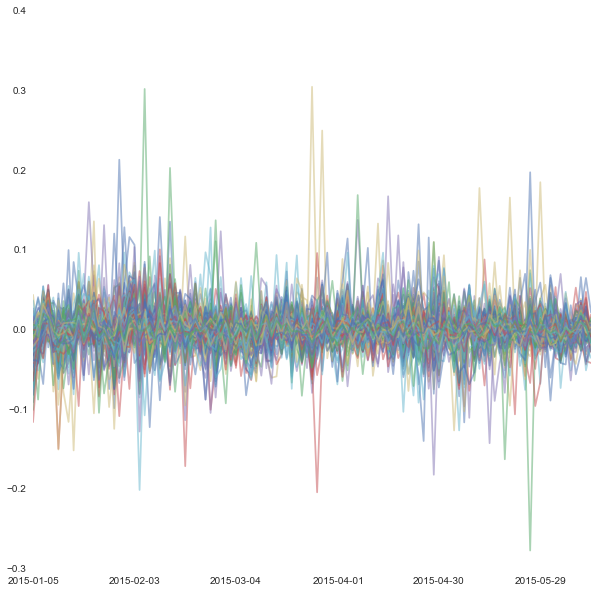

In [33]:
log_returns = np.log(returns)
log_returns.plot(legend=False, figsize=(10, 10), alpha=0.5)
plt.show()

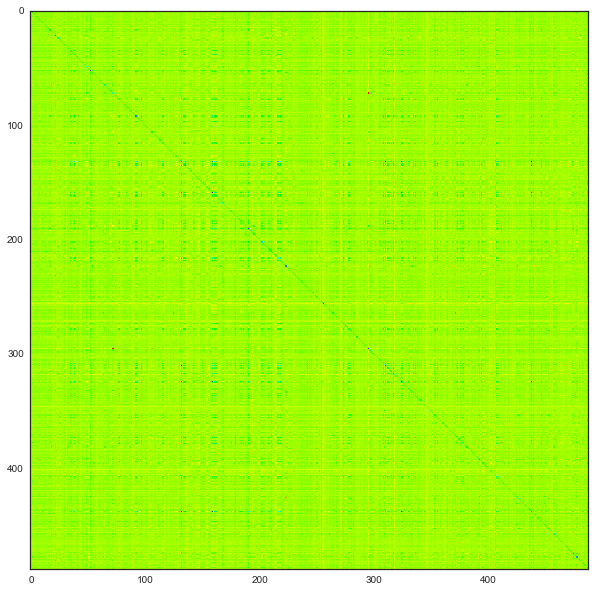

In [59]:
plt.figure(figsize=(10, 10))
sns.set_style("white")
plt.imshow(np.cov(log_returns.values.T), cmap="hsv", interpolation="Nearest")
plt.show()

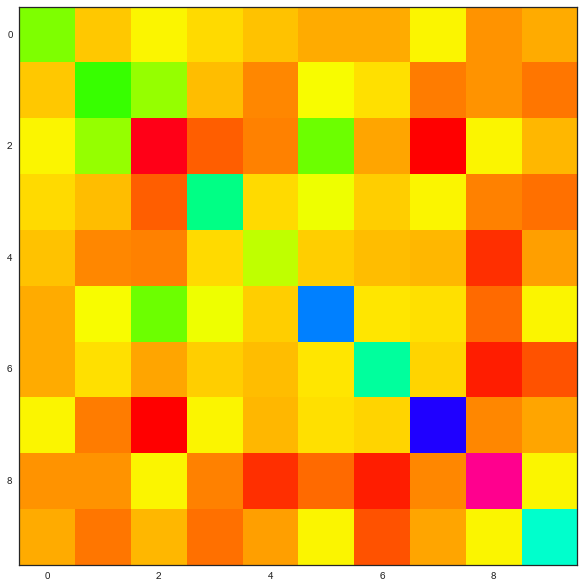

In [61]:
plt.figure(figsize=(10, 10))
sns.set_style("white")
plt.imshow(np.cov(log_returns.values.T[:10]), cmap="hsv", interpolation="Nearest")
plt.show()

In [88]:
industry_lr = pd.DataFrame()
for i in xrange(10):
    mask = const[const.Sector == i].Symbol.values.tolist()
    industry_lr[i] = np.median(log_returns[[m for m in mask if m in log_returns.columns]], axis=1)

In [89]:
industry_lr.index = log_returns.index

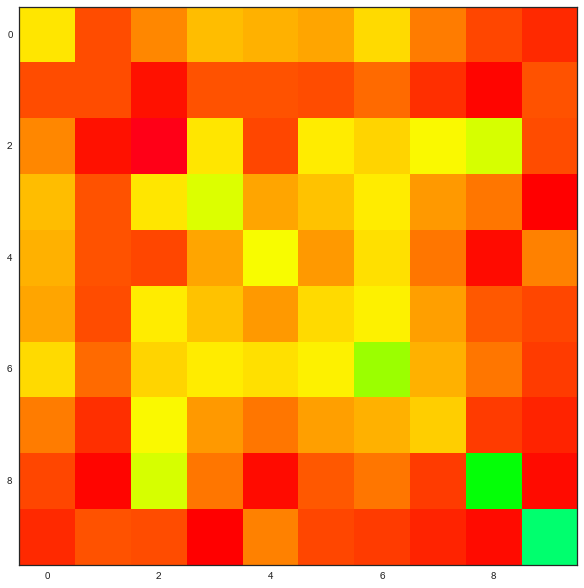

In [91]:
plt.figure(figsize=(10, 10))
sns.set_style("white")
plt.imshow(np.cov(industry_lr.values.T), cmap="hsv", interpolation="Nearest")
plt.show()